# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [3]:
#%%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', eps=0.01):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.eps = eps

    def get_distance(self, X, y):
        distance = np.sum((X**2), axis=1).reshape(-1, 1) + \
                    np.sum((y**2), axis=1) - 2*X.dot(y.T)
        distance[distance < 0] = 0
        return np.sqrt(distance)

    def init_centroids_kmpp(self, X):
        for centroid in range(1, self.k):
            min_distance = np.min(
                self.get_distance(X, self.centroids[:centroid, :]), axis=1)
            proba = min_distance / np.sum(min_distance)
            self.centroids[centroid] = X[np.random.choice(X.shape[0],
                                                          p=proba,
                                                          replace=False)]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        N = X.shape[0]
        D = X.shape[1]

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(N)

        # Массив с центройдами кластеров
        self.centroids = X[np.random.choice(N, size=self.k, replace=False)]
        if self.init == 'k-means':
            self.init_centroids_kmpp(X)

        new_centroids = np.empty((self.k, D))
        for _ in range(self.max_iter):
            self.labels = np.argmin(
                self.get_distance(X, self.centroids), axis=1)
            for centroid in range(self.k):
                if np.any(self.labels == centroid, axis=0):
                    new_centroids[centroid] = np.mean(
                        X[self.labels == centroid], axis=0)
                else:
                    new_centroids[centroid] = X[np.random.choice(N)]
            if np.all(np.abs(new_centroids - self.centroids) < self.eps):
                break

            self.centroids = new_centroids

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """

        return np.argmin(self.get_distance(X, self.centroids), axis=1)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', eps=0.01, batch_size=10):
        super().__init__(k, metric, max_iter, random_state, init, eps)
        self.batch_size = batch_size

    def __fit__(self, X, y=None):

        N = X.shape[0]
        D = X.shape[1]

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(N)

        # Массив с центройдами кластеров
        self.centroids = X[np.random.choice(N, size=self.k, replace=False)]

        if self.init == 'k-means':
            self.init_centroids_kmpp(X)

        new_centroids = np.empty((self.k, D))
        for _ in range(self.max_iter):
            X_batch = X[np.random.choice(N, size=self.batch_size,
                                         replace=False)]
            self.labels = np.argmin(self.get_distance(X_batch,
                                                      self.centroids), axis=1)
            for centroid in range(self.k):
                if np.any(self.labels == centroid, axis=0):
                    new_centroids[centroid] = np.mean(
                        X_batch[self.labels == centroid], axis=0)
                else:
                    new_centroids[centroid] = X_batch[np.random.choice(N)]
            if np.all(np.abs(new_centroids - self.centroids) < self.eps):
                break

            self.centroids = new_centroids

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [5]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1,
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

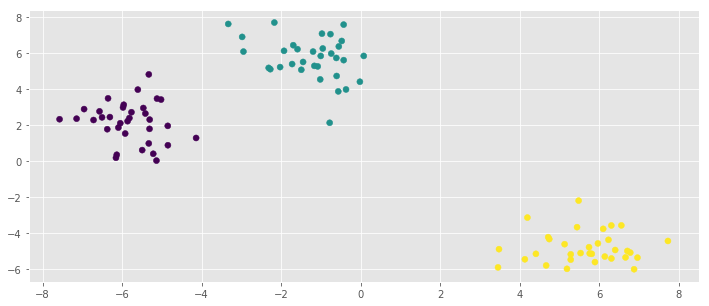

In [6]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

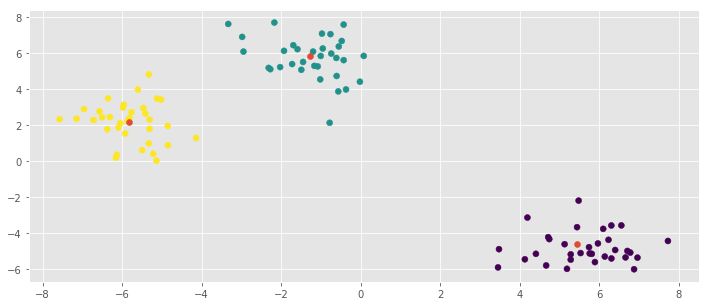

In [8]:
## Работоспособность MyKmeans
my_kmeans = MyKmeans(k=3)
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=prediction)
plt.scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1])

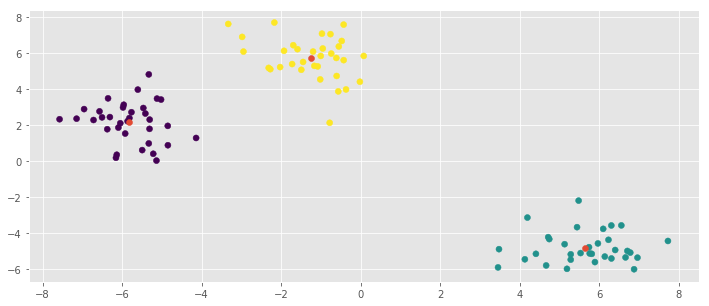

In [9]:
## Работоспособность MyKmeans++
my_kmeans = MyKmeans(k=3, init="k-means")
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=prediction)
plt.scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1])

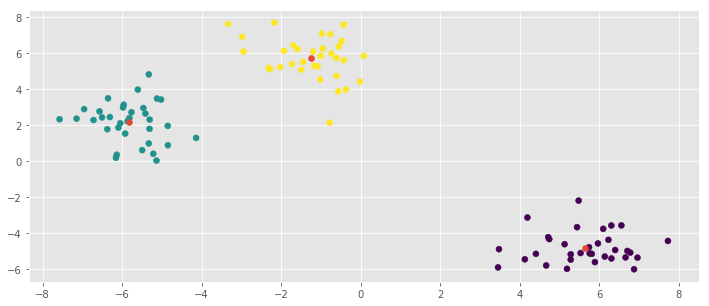

In [10]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
my_kmeans = MiniBatchKMeans(k=3)
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=prediction)
plt.scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1])

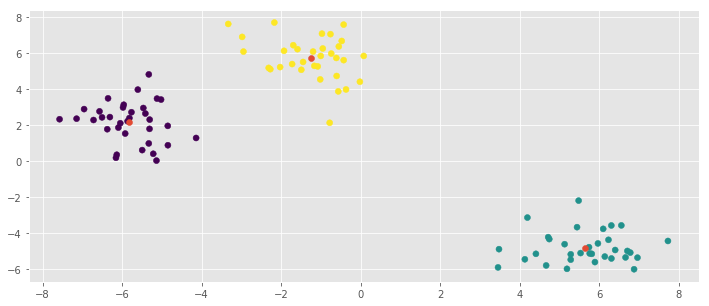

In [11]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
my_kmeans = MiniBatchKMeans(k=3, init="k-means")
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=prediction)
plt.scatter(my_kmeans.centroids[:, 0], my_kmeans.centroids[:, 1])

In [12]:
## Время выполнения алгоритма Kmeans из sklearn
start = time()

kmeans = KMeans(n_clusters=3, init='random', max_iter=1000, n_init=1)
kmeans.fit(X)
prediction = kmeans.predict(X)

print("%.3fms" % (1000*(time() - start)))

8.432ms


In [13]:
## Время выполнения алгоритма MyKmeans
start = time()

my_kmeans = MyKmeans(k=3)
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

print("%.3fms" % (1000*(time() - start)))

0.496ms


In [14]:
## Время выполнения алгоритма MyKmeans++
start = time()

my_kmeans = MyKmeans(k=3, init='k-means')
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

print("%.3fms" % (1000*(time() - start)))

0.993ms


In [15]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
start = time()

my_kmeans = MiniBatchKMeans(k=3)
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

print("%.3fms" % (1000*(time() - start)))

0.496ms


In [16]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
start = time()

my_kmeans = MiniBatchKMeans(k=3, init='k-means')
my_kmeans.fit(X)
prediction = my_kmeans.predict(X)

print("%.3fms" % (1000*(time() - start)))

0.992ms


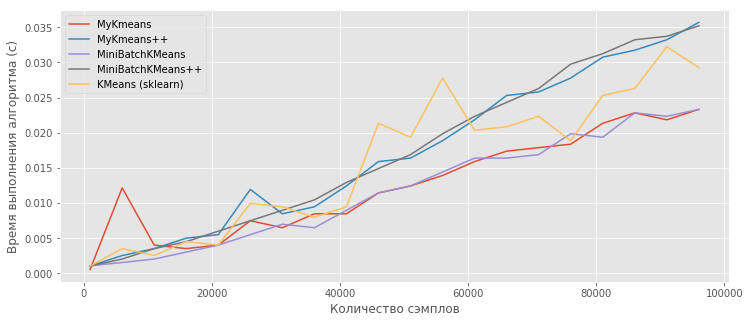

In [17]:
models = (
    MyKmeans(k=3),
    MyKmeans(k=3, init='k-means'),
    MiniBatchKMeans(k=3),
    MiniBatchKMeans(k=3, init='k-means'),
    KMeans(n_clusters=3, init='random', max_iter=1000, n_init=1)
)

labels = ("MyKmeans", "MyKmeans++",
          "MiniBatchKMeans", "MiniBatchKMeans++", "KMeans (sklearn)")

samples = range(1000, 100001, 5000)
results = np.empty((5, len(samples)))
for i, sample in enumerate(samples):
    X, _ = make_blobs(n_samples=sample, n_features=2, centers=3, cluster_std=1,
                      center_box=(-10.0, 10.0), shuffle=False,
                      random_state=1234)

    for j, model in enumerate(models):
        start = time()
        model.fit(X)
        results[j][i] = time() - start

for i, model in enumerate(models):
    plt.plot(samples, results[i], label=labels[i])

plt.xlabel('Количество сэмплов')
plt.ylabel('Время выполнения алгоритма (с)')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [18]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [19]:
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis='columns')
df_sns_scaled = (df_sns - df_sns.mean()) / df_sns.std()

In [20]:
def print_cluster_info(df, df_scaled, model):
    model.fit(df_scaled.values)

    df['cluster'] = model.labels
    counts = df.cluster.value_counts().sort_index()
    for cluster in range(9):
        print('Cluster: ' + str(cluster+1))
        print('Number of students: ' + str(counts[cluster]))
        print("Popular key words:")
        key_words = df[df.cluster == cluster].drop(['cluster'], axis=1).mean()
        print(key_words.T.sort_values(ascending=False)[:8])
        print('_'*22)

In [21]:
## MyKMeans
print_cluster_info(df_sns, df_sns_scaled, MyKmeans(k=9))

Cluster: 1
Number of students: 1054
Popular key words:
music         2.304554
hair          2.054080
rock          1.427894
god           1.137571
basketball    1.107211
cute          1.031309
band          1.021822
football      0.990512
dtype: float64
______________________
Cluster: 2
Number of students: 565
Popular key words:
dance       2.502655
dress       2.357522
hair        0.955752
music       0.953982
cute        0.815929
shopping    0.803540
blonde      0.697345
god         0.596460
dtype: float64
______________________
Cluster: 3
Number of students: 2022
Popular key words:
death    1.288328
music    0.861029
god      0.860040
hair     0.442631
dance    0.429773
band     0.374876
die      0.335312
cute     0.328882
dtype: float64
______________________
Cluster: 4
Number of students: 18045
Popular key words:
music         0.557495
god           0.346800
dance         0.262954
band          0.238847
hair          0.189083
cute          0.173511
football      0.165863
basketbal

Примечание: после перезапуска кластеры меняются и данная интерпретация теряет смысл

Описание кластеров:
1. Люди, увлекающиеся рок музыкой, немного религиозные
2. Люди, увлекающиеся танцами
3. Религиозные люди
4. Большой кластер, плохо интерпретируется
5. Похоже на темы всяких журналов для подростков
6. Тусовщики
7. Люди, увлекающиеся шоппингом
8. Спортсмены
9. Самый маленький кластер, люди любят торговые центры и, возможно, депрессивную музыку

In [22]:
## MyKMeans++
print_cluster_info(df_sns, df_sns_scaled, MyKmeans(k=9, init='k-means'))

Cluster: 1
Number of students: 2729
Popular key words:
god       1.599853
sexy      1.104434
music     0.835471
dance     0.572737
hair      0.571638
cute      0.548553
church    0.519971
jesus     0.399780
dtype: float64
______________________
Cluster: 2
Number of students: 929
Popular key words:
band        3.672766
marching    1.260495
music       1.259419
hair        0.540366
god         0.539290
dance       0.463940
rock        0.376749
sports      0.322928
dtype: float64
______________________
Cluster: 3
Number of students: 18819
Popular key words:
music         0.529305
dance         0.281311
god           0.254105
soccer        0.192571
hair          0.190765
cute          0.186673
basketball    0.173282
rock          0.155109
dtype: float64
______________________
Cluster: 4
Number of students: 3326
Popular key words:
shopping    1.512628
music       1.212568
hair        1.090198
dance       0.868310
mall        0.694227
cute        0.693325
swimming    0.657547
god         0.4

Описание кластеров:
1. Немного религиозные люди
2. Люди, увлекаюшщиеся музыкрй
3. Большой кластер, сложно интерпертируется
4. Шоппинг, музыка, полагаю, что это девушки
5. Ярко выраженнные спортсмены
6. Очень маленький кластер, полагаю, что девушки
7. Спортсмены
8. Спортсмены
9. Религиозные любители музыки

In [23]:
## MyKMeans с MiniBatchMyKMeans
print_cluster_info(df_sns, df_sns_scaled, MiniBatchKMeans(k=9))

Cluster: 1
Number of students: 1385
Popular key words:
god         2.878700
church      2.555235
music       1.061372
jesus       0.967509
dance       0.951625
hair        0.477256
band        0.464982
shopping    0.462816
dtype: float64
______________________
Cluster: 2
Number of students: 645
Popular key words:
drunk     2.037209
hair      1.699225
sex       1.035659
music     1.026357
blonde    0.750388
god       0.703876
dance     0.675969
drugs     0.669767
dtype: float64
______________________
Cluster: 3
Number of students: 3951
Popular key words:
cute        1.354594
dance       1.050620
music       0.809922
hair        0.492027
shopping    0.465705
god         0.394584
mall        0.312073
sexy        0.309795
dtype: float64
______________________
Cluster: 4
Number of students: 1595
Popular key words:
dress       1.505956
dance       0.769279
music       0.763636
hair        0.540439
shopping    0.535423
god         0.457053
cute        0.388715
band        0.381191
dtype: floa

Описание кластеров:
1. Очень религиозные люди
2. Тусовщики
3. Девушки
4. Похож на прошлый кластер
5. Похоже на темы всяких журналов для подростков
6. Рок музыка и немного спорта
7. Снова большой непонятный кластер
8. Люди, людят хорошо одеться
9. Спортсмены

Мне не очень понравилось разбиение этим методом

In [24]:
## MyKMeans++ с MiniBatchMyKMeans
print_cluster_info(df_sns, df_sns_scaled, MiniBatchKMeans(k=9, init='k-means'))

Cluster: 1
Number of students: 2868
Popular key words:
music         1.264644
church        1.106346
god           0.894351
sports        0.877615
soccer        0.503835
basketball    0.475941
dance         0.472803
hair          0.466527
dtype: float64
______________________
Cluster: 2
Number of students: 2391
Popular key words:
sexy        1.398996
music       0.697198
cute        0.501464
dance       0.481807
hair        0.436219
god         0.388122
shopping    0.349226
mall        0.294019
dtype: float64
______________________
Cluster: 3
Number of students: 320
Popular key words:
band        5.968750
marching    2.131250
music       1.493750
god         0.625000
dance       0.534375
hair        0.421875
shopping    0.371875
rock        0.356250
dtype: float64
______________________
Cluster: 4
Number of students: 105
Popular key words:
die         5.742857
music       1.409524
swimming    1.352381
god         1.333333
death       1.238095
hair        1.190476
dance       0.895238
s

Описание кластеров:
1. Религиозные люди, которые также любят послушать музыку
2. Девушки
3. Музыканты
4. Маленький кластер, депрессиваня или религиозная музыка ???
5. Снова большой непонятный кластер
6. Спортсмены
7. Похоже на темы всяких журналов для подростков
8. Религиозные спортсмены
9. Девушки спортсмены ???

## Вывод
Пытаясь проинтерперетировать образовавшиеся кластеры, я заметил, что кластеры, разбитые алгоритмами с minibatch, 
интерпретировать сложнее. Исходя из этого я могу составить свою субъективную оценку работы алгоритмов:
    1. K-means++. Могу подметить, что при анализе результатов K-means++ встречались кластеры, которые так и напрашивались 
    на то, чтобы объединить их в один (кластеры спортсменов), а также там был один очень маленький непонятный кластер. 
    Но интерпретация, как мне показалось, была более однозначна, чем в обычном K-means, поэтому улучшенный метод на первом месте.
    2. K-means. В целом, результаты мне понравились.
    3. MiniBatch K-means и MiniBatch K-means++. Не буду говорить, какой из них хуже (тем более, что это слишком субъективно).
    На мой взгляд они показали результат качеством ниже, чем прошлые 2 алгоритма.